In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

In [9]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [10]:
tab = Table.read('/home/apizzuto/Nova/source_list/appendix.tex')
df = tab.to_pandas()
coords = SkyCoord(frame="galactic", l=df['$l$']*u.degree, b=df['$b$']*u.degree)
equatorial = coords.icrs
df['ra'] = equatorial.ra.deg
df['dec'] = equatorial.dec.deg
df['gamma'] = [~np.char.startswith(fl, '$<$') for fl in df['Flux']] 
df = df.replace(['-'], np.nan)
df[u'$t_2$'] = df[u'$t_2$'].astype(float)

In [11]:
max_time_window = 5.
df = df[~df['gamma']]
df['$t_2$'][np.isnan(df['$t_2$'])] = max_time_window
df['mjd'] = np.array([Time(pt, '%Y-%m-%d').mjd for pt in df['Peak Time']])
during_greco = (df['mjd'] > greco_ana.mjd_min) & (df['mjd'] + df['$t_2$'] < greco_ana.mjd_max)
df = df[during_greco]

In [12]:
ras = df['ra']
decs = df['dec']
delta_t = df['$t_2$']
delta_t = np.minimum(delta_t, np.ones_like(delta_t)*max_time_window)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

src = cy.utils.Sources(ra=np.radians(ras), 
                       dec=np.radians(decs), 
                       mjd=df['mjd'], 
                       sigma_t=np.zeros_like(delta_t), 
                       t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials = 5000
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 5000 background trials using 10 cores:
       5000/5000 trials complete.   


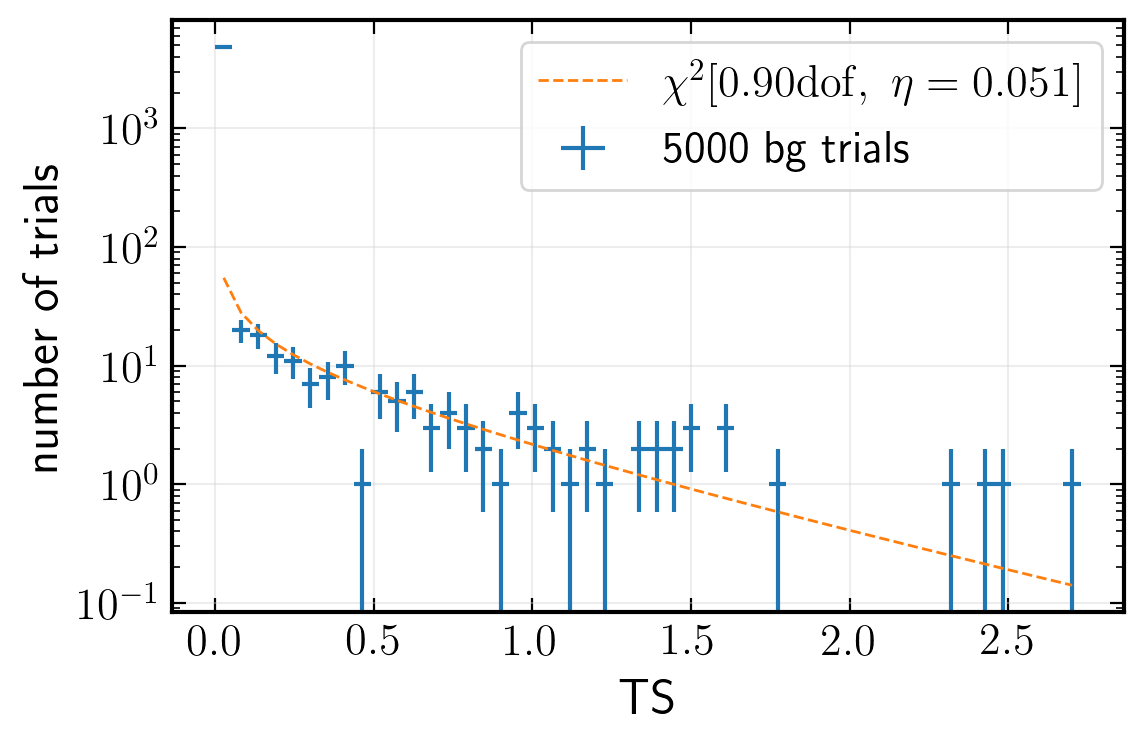

In [14]:
fig, ax = plt.subplots(dpi=200)

h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [15]:
tr = cy.get_trial_runner(conf, ana=greco_ana, src=src, inj_conf={'flux': cy.hyp.PowerLawFlux(2.)})
trials = tr.get_many_fits(10, n_sig=100., logging=False, seed=1)

In [16]:
print(trials.ts, '\n', trials.ns, '\n', trials.gamma)

[40.78962557 40.19577874 59.07093277 49.58978017 47.33045671 38.58070561
 27.9496953  28.75001812 40.10632631 41.73668832] 
 [81.10898173 66.00580006 76.87119552 79.1438693  73.17449712 56.85706531
 55.07103282 53.30805395 81.18942649 89.51397083] 
 [2.11742885 1.76383505 1.81436305 1.98297385 1.78682425 1.97021526
 2.08104745 1.93047402 2.14206077 2.20621315]


In [33]:
tr.sig_injs[0].flux[0].gamma

2

In [ ]:
trials

In [18]:
n_sigs = np.r_[:101:10]

trials = [tr.get_many_fits(100, n_sig=n_sig, 
                           logging=False, 
                           seed=n_sig) for n_sig in n_sigs]

for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials)

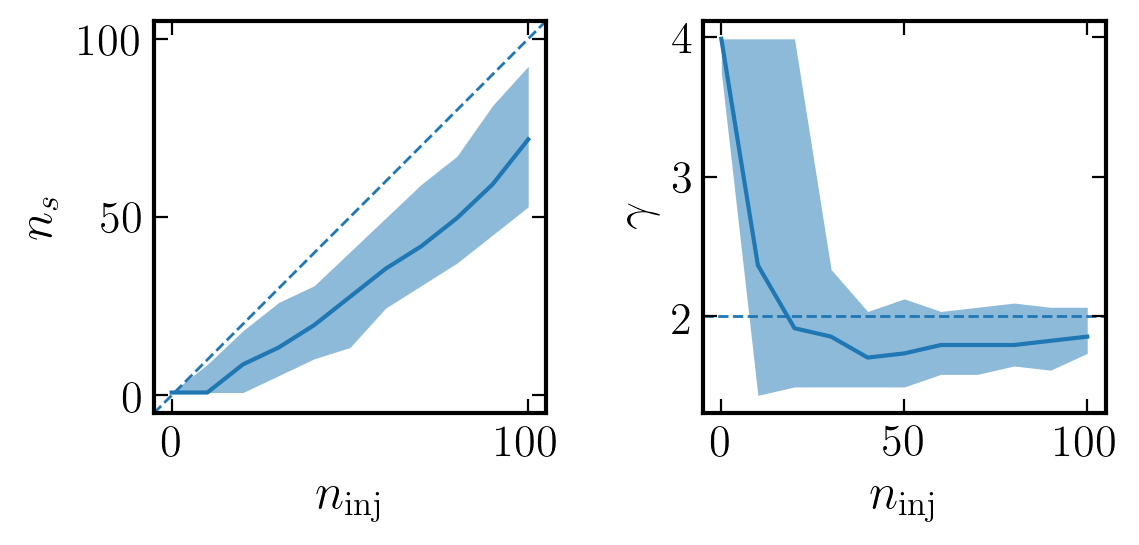

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200)

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()

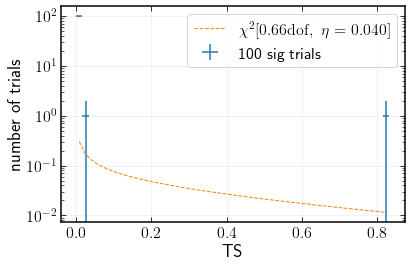

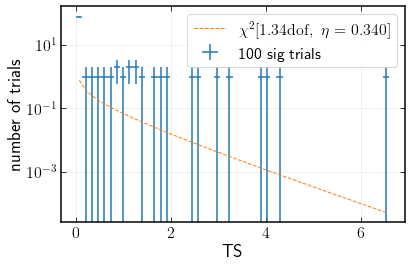

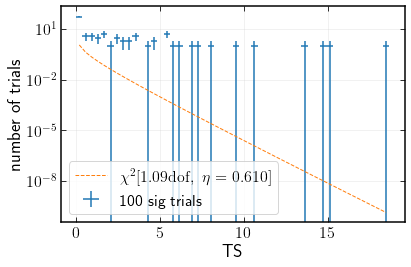

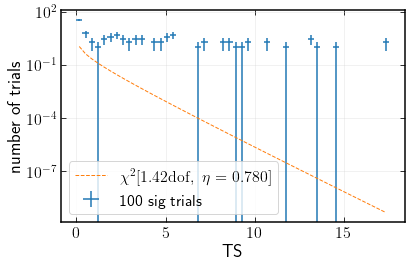

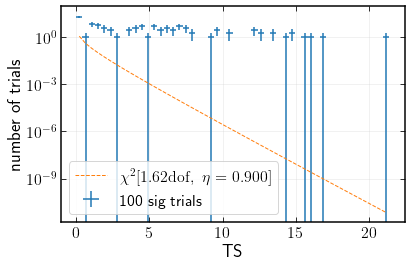

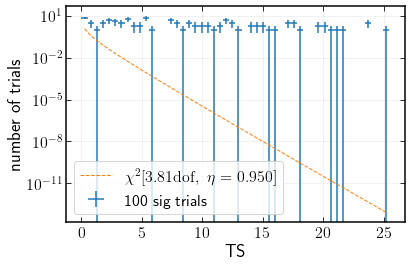

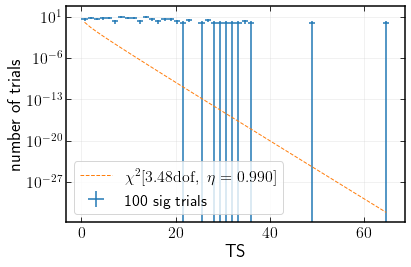

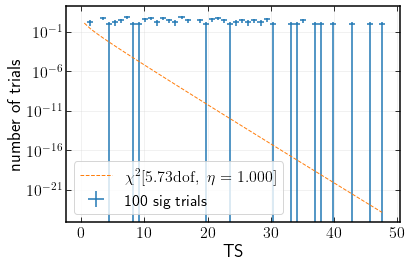

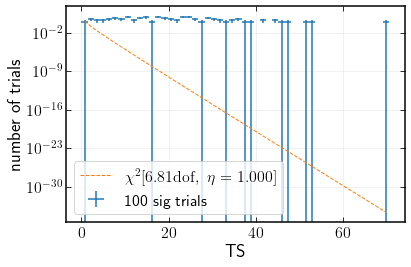

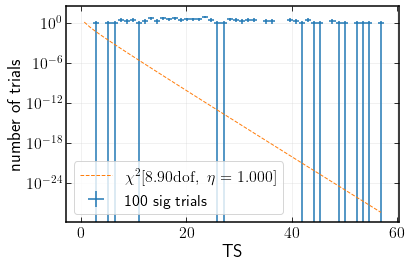

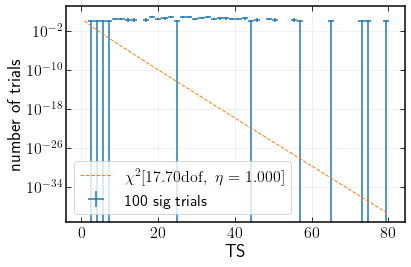

In [61]:
for trial in trials:
    fig, ax = plt.subplots()

    dist = cy.dists.Chi2TSD(trial)
    h = dist.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True,
              label='{} sig trials'.format(dist.n_total))

    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
                label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(dist.ndof, dist.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
    plt.tight_layout()
    plt.show()